In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:

import numpy as np
import torch

data = torch.load("gdrive/MyDrive/filtered_preprocessed_images_with_metadata_and_target.pt.nosync")

In [3]:
def flip_image(image):
  left_side_count = np.count_nonzero(image[:, :image.shape[1] // 2])
  right_side_count = np.count_nonzero(image[:, image.shape[1] // 2:])

  if left_side_count < right_side_count:
      flipped_image = np.fliplr(image)
  else:
      flipped_image = image
  return flipped_image

In [4]:
features = []
metadata = []
y = []

for image, target, metadata_ in data:
    features.append(image)
    metadata.append(metadata_)
    y.append(target)

features = torch.tensor(np.array(features).reshape((-1, 1, 512, 512))).float()
metadata = torch.tensor(np.asarray(metadata).reshape((-1, 2))).float()
y = torch.tensor(y).view(-1, 1).float()

In [5]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

X1_train, X1_val, X2_train, X2_val, y_train, y_val = train_test_split(features, metadata, y, test_size=0.15,
                                                                      random_state=3451)

train_dataset = TensorDataset(X1_train, X2_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=32)

val_dataset = TensorDataset(X1_val, X2_val, y_val)
val_dataloader = DataLoader(val_dataset, batch_size=32)

In [6]:
def probabilistic_f1(labels, predictions, beta=1):
    pTP = np.sum(labels * predictions)
    pFP = np.sum((1 - labels) * predictions)
    num_positives = np.sum(labels)  #  = pTP+pFN

    pPrecision = pTP / (pTP + pFP)
    pRecall = pTP / num_positives

    beta_squared = beta ** 2

    if pPrecision > 0 and pRecall > 0:
        pF1 = (1 + beta_squared) * pPrecision * pRecall / (beta_squared * pPrecision + pRecall)
        return pF1
    else:
        return 0

In [7]:
results = {}

In [8]:
""" Parts of the U-Net model """

import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)


    def forward(self, x):
        out = self.up(x)
        return self.conv(out)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

""" Full assembly of the parts to form the complete network """

import torch.nn.functional as F


class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.n_channels = 1
        self.n_classes = 1


        self.inc = DoubleConv(self.n_channels, 16)
        self.down1 = Down(16, 32)
        self.down2 = Down(32, 64)
        self.down3 = Down(64, 128)
        self.down4 = Down(128, 256)
        self.down5 = Down(256, 512)
        self.down6 = Down(512, 1024)

        self.adaptive_pool = nn.AdaptiveMaxPool2d(output_size=1)
        self.flatten = nn.Flatten()


    def forward(self, x):
        out = self.inc(x)
        out = self.down1(out)
        out = self.down2(out)
        out = self.down3(out)
        out = self.down4(out)
        out = self.down5(out)
        out = self.down6(out)

        out = self.adaptive_pool(out)
        return self.flatten(out)

encoder = UNet()

In [9]:
state = torch.load("gdrive/MyDrive/autoencoder_v4.pth", map_location=torch.device('cpu'))
state = {k: v for k, v in state.items() if not (k.startswith('up') or k.startswith('outc'))}
encoder.load_state_dict(state)

<All keys matched successfully>

In [10]:
output = encoder(features[:3])
output.shape

torch.Size([3, 1024])

In [11]:
import torch.nn as nn


class DeepNN(nn.Module):
    def __init__(self, encoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder

        self.seq_1 = nn.Sequential(
            nn.Linear(1024, 256),
            nn.Dropout(0.15),
            nn.Tanh(),
            nn.Linear(256, 64),
            nn.Tanh(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
        self.seq_2 = nn.Sequential(
            nn.Linear(2, 2),
            nn.ReLU(),
            nn.Linear(2, 1),
            nn.Sigmoid()
        )
        self.linear = nn.Linear(2, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x1, x2):
        out_1 = self.encoder(x1)
        out_1 = self.seq_1(out_1)
        out_2 = self.seq_2(x2)

        out = torch.cat([out_1, out_2], dim=1)
        out = self.linear(out)
        out = self.sigmoid(out)
        return out

In [12]:
from torch import optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score

encoder = UNet()
state = torch.load("gdrive/MyDrive/autoencoder_v4.pth", map_location=torch.device('cpu'))
state = {k: v for k, v in state.items() if not (k.startswith('up') or k.startswith('outc'))}
encoder.load_state_dict(state)
model = DeepNN(encoder).to('cuda')

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 100

train_losses = []
val_losses = []
train_f1_scores = []
val_f1_scores = []

for epoch in range(num_epochs):
    plt.clf()
    running_loss = 0.0
    model.train()  # Set the model to training mode
    train_predictions = []
    train_labels = []

    for i, data in enumerate(train_dataloader, 0):
        inputs1, inputs2, labels = data
        inputs1, inputs2, labels = inputs1.to('cuda'), inputs2.to('cuda'), labels.to('cuda')

        optimizer.zero_grad()

        outputs = model(inputs1*255, inputs2)
        loss = criterion(outputs, labels)

        train_predictions.extend(outputs.cpu().detach().numpy().flatten())
        train_labels.extend(labels.cpu().detach().numpy().flatten())

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / (i + 1)
    train_losses.append(train_loss)
    train_f1 = probabilistic_f1(np.asarray(train_labels), np.round(train_predictions, decimals=2))
    train_f1_scores.append(train_f1)

    y_pred = np.asarray(train_predictions) > 0.5
    train_accuracy = accuracy_score(train_labels, y_pred)

    # Validation
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    val_predictions = []
    val_labels = []

    with torch.no_grad():
        for i, data in enumerate(val_dataloader, 0):
            inputs1, inputs2, labels = data
            inputs1, inputs2, labels = inputs1.to('cuda'), inputs2.to('cuda'), labels.to('cuda')


            outputs = model(inputs1*255, inputs2)
            loss = criterion(outputs, labels)

            val_predictions.extend(outputs.cpu().detach().numpy().flatten())
            val_labels.extend(labels.cpu().detach().numpy().flatten())

            val_loss += loss.item()

    val_loss = val_loss / (i + 1)
    val_losses.append(val_loss)
    val_f1 = probabilistic_f1(np.asarray(val_labels), np.asarray(val_predictions))
    val_f1_scores.append(val_f1)

    y_pred = np.asarray(val_predictions) > 0.5
    val_accuracy = accuracy_score(val_labels, y_pred)

    print(
        f'Epoch {epoch + 1}, Validation Loss: {round(val_loss, 3)}, F1 Score: {round(val_f1, 3)}, Val Acc: {round(val_accuracy, 3)}, Training Loss: {round(train_loss, 3)}, F1 Score: {round(train_f1, 3)}, Train Acc: {round(train_accuracy, 3)}')



Epoch 1, Validation Loss: 0.703, F1 Score: 0.549, Val Acc: 0.549, Training Loss: 0.694, F1 Score: 0.524, Train Acc: 0.507
Epoch 2, Validation Loss: 0.699, F1 Score: 0.54, Val Acc: 0.549, Training Loss: 0.692, F1 Score: 0.533, Train Acc: 0.531
Epoch 3, Validation Loss: 0.7, F1 Score: 0.544, Val Acc: 0.549, Training Loss: 0.692, F1 Score: 0.53, Train Acc: 0.531
Epoch 4, Validation Loss: 0.699, F1 Score: 0.541, Val Acc: 0.549, Training Loss: 0.691, F1 Score: 0.531, Train Acc: 0.531
Epoch 5, Validation Loss: 0.7, F1 Score: 0.544, Val Acc: 0.549, Training Loss: 0.691, F1 Score: 0.531, Train Acc: 0.531
Epoch 6, Validation Loss: 0.699, F1 Score: 0.543, Val Acc: 0.549, Training Loss: 0.691, F1 Score: 0.532, Train Acc: 0.531
Epoch 7, Validation Loss: 0.699, F1 Score: 0.54, Val Acc: 0.549, Training Loss: 0.691, F1 Score: 0.53, Train Acc: 0.531
Epoch 8, Validation Loss: 0.699, F1 Score: 0.545, Val Acc: 0.549, Training Loss: 0.69, F1 Score: 0.531, Train Acc: 0.531
Epoch 9, Validation Loss: 0.697, 

<Figure size 640x480 with 0 Axes>

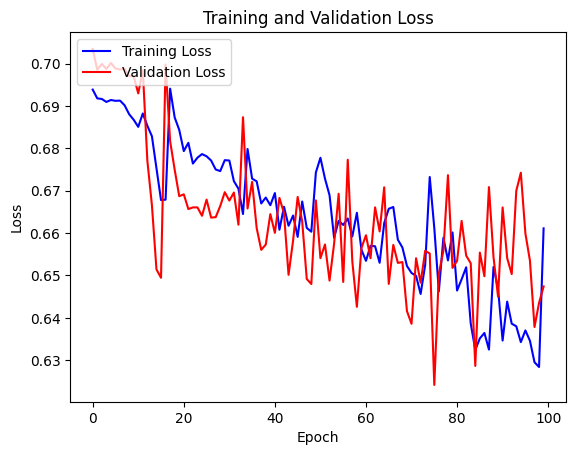

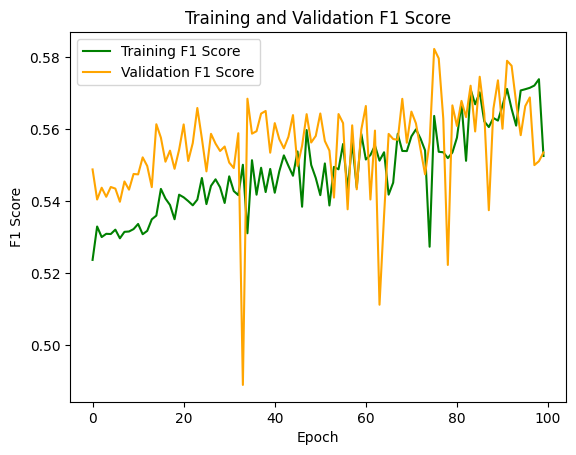

In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score


plt.figure(1)
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.title('Training and Validation Loss')

plt.figure(2)
plt.plot(train_f1_scores, label='Training F1 Score', color='green')
plt.plot(val_f1_scores, label='Validation F1 Score', color='orange')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend(loc='upper left')
plt.title('Training and Validation F1 Score')

plt.show(block=False)

y_pred = np.asarray(val_predictions) > 0.5
accuracy = accuracy_score(val_labels, y_pred)
precision = precision_score(val_labels, y_pred, average='weighted')
recall = recall_score(val_labels, y_pred, average='weighted')
auroc = roc_auc_score(val_labels, val_predictions, multi_class='ovr')

clf_name = "DeepNN - val"
results[clf_name] = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': val_f1,
    'AUROC': auroc,
}
y_pred = np.asarray(train_predictions) > 0.5
accuracy = accuracy_score(train_labels, y_pred)
precision = precision_score(train_labels, y_pred, average='weighted')
recall = recall_score(train_labels, y_pred, average='weighted')
auroc = roc_auc_score(train_labels, train_predictions, multi_class='ovr')

clf_name = "DeepNN - train"
results[clf_name] = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': train_f1,
    'AUROC': auroc,
}